In [1]:
from os import listdir
from os.path import join, isfile
from typing import List

In [2]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data: List[List[int]] = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [3]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [4]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of vehicles.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [6]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [7]:
toolbox = base.Toolbox()

In [8]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [9]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
def sort_rides(vehicle_rides):
    def sort_ride(ride):
        a, b, x, y, s, f = ride[1]
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance
    
    return sorted(vehicle_rides, key=lambda ride: sort_ride(ride))

def get_rides_from_ind(individual):
    vehicles_rides = np.full(F, None)
    
    for i, vehicle in enumerate(individual):
        v_r = vehicles_rides[vehicle]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        vehicles_rides[vehicle] = v_r

    return vehicles_rides

def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


In [11]:
def calc_fitness(car_rides):
    fitness = 0
    step = 0
    pos = [0, 0]
    
    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, s, f = ride
        origin = [a, b]
        destiny = [x, y]
        earliest_start = s
        latest_finish = f
        
        # 1.- Go to origin.
        step += dis(pos, origin)
        
        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
          fitness += B
          step = earliest_start
          
        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des
        
        #4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
          fitness += dis_ori_des
          
        # 5.- Update position.
        pos = destiny
                  
        # 6.- Check if reached max distance with one vehicle.
        if step > T:
          break
    
    return fitness
        
def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0

    for car_rides in all_rides:
        if car_rides is not None:
            fitness += calc_fitness(car_rides)

    return fitness,


In [12]:
NIND = 30

pop = toolbox.population(n=NIND)
# print(f"Population: {pop}")

In [13]:
# ind = toolbox.individual()

# print("Individuo ANTES de evaluar")
# print(ind)
# print(ind.fitness.valid)
# print("\n")

# ind.fitness.values = eval_ind(ind)

# print("Individuo TRAS evaluar")
# print(ind)
# print(ind.fitness.valid)
# print(ind.fitness)

In [14]:
TOURNSIZE, INDPB = 3, 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [15]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [16]:
CXPB, MUTPB, NGEN = 0.7, 0.2, 50

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(f"La mejor solucion encontrada es: {best_sol}")


El resultado de la evolución es:
gen	nevals	avg        	std    	min        	max        
0  	30    	1.57955e+07	89146.6	1.56195e+07	1.59574e+07
1  	26    	1.58522e+07	79122.5	1.56293e+07	1.59574e+07
2  	24    	1.58637e+07	79274.8	1.56606e+07	1.60131e+07
3  	25    	1.58821e+07	84585  	1.57389e+07	1.60131e+07
4  	20    	1.59372e+07	62920.2	1.57525e+07	1.60363e+07
5  	23    	1.59514e+07	73443.2	1.57356e+07	1.60477e+07
6  	25    	1.59778e+07	79135.7	1.57678e+07	1.61013e+07
7  	19    	1.5995e+07 	75122.5	1.57715e+07	1.60988e+07
8  	22    	1.60424e+07	50681.3	1.58889e+07	1.61061e+07
9  	28    	1.605e+07  	56214  	1.58499e+07	1.61112e+07
10 	22    	1.60761e+07	54401  	1.58467e+07	1.61172e+07
11 	22    	1.6072e+07 	60008.7	1.59106e+07	1.61459e+07
12 	26    	1.60763e+07	73415.1	1.58943e+07	1.61459e+07
13 	25    	1.60903e+07	74055.7	1.58087e+07	1.61459e+07
14 	21    	1.61065e+07	60794.6	1.59135e+07	1.61605e+07
15 	24    	1.61088e+07	67920.4	1.58877e+07	1.61605e+07
16 	19    	1.61266e+07	50063.3	1

[]

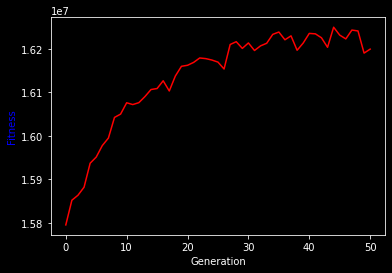

In [17]:
gen = logbook.select("gen")
avgs = logbook.select("avg")

fig = plt.figure()

ax = plt.gca()
line = ax.plot(gen, avgs, "r-", label="Average Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness", color="b")

plt.plot()

In [18]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

vehicles_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in vehicles_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")